In [ ]:
%%capture
!apt-get update
!apt-get install libgdal-dev -y
!apt-get install python-gdal -y
!apt-get install python-numpy python-scipy -y
!pip install rasterio
!pip install fiona
!pip install geopandas
!pip install PyCRS
!pip install -i https://test.pypi.org/simple/ gis-utils-pkg-dillhicks==0.0.76

In [ ]:
from math import sqrt
import torch
import os
from torch import Tensor
from tqdm.autonotebook import tqdm
from torch import nn
from torch.cuda import amp
import torch.optim as optim
import torchvision.transforms as transforms
import torch.utils.data.dataset
import gis_utils.raster as raster
from rasterio.plot import reshape_as_image
import rasterio
from rasterio.plot import reshape_as_raster, reshape_as_image

# Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/srcnn/srcnn_tiles.zip .
!unzip srcnn_tiles.zip 

Streaming output truncated to the last 5000 lines.
  inflating: train/hr_S2_lap_2020-05_PuertoFalsa_planetscope_optical_02_11.tif  
  inflating: train/hr_S2_lap_2020-05_PuertoFalsa_planetscope_optical_02_12.tif  
  inflating: train/hr_S2_lap_2020-05_PuertoFalsa_planetscope_optical_03_01.tif  
  inflating: train/hr_S2_lap_2020-05_PuertoFalsa_planetscope_optical_03_02.tif  
  inflating: train/hr_S2_lap_2020-05_PuertoFalsa_planetscope_optical_03_03.tif  
  inflating: train/hr_S2_lap_2020-05_PuertoFalsa_planetscope_optical_03_04.tif  
  inflating: train/hr_S2_lap_2020-05_PuertoFalsa_planetscope_optical_03_05.tif  
  inflating: train/hr_S2_lap_2020-05_PuertoFalsa_planetscope_optical_03_06.tif  
  inflating: train/hr_S2_lap_2020-05_PuertoFalsa_planetscope_optical_03_07.tif  
  inflating: train/hr_S2_lap_2020-05_PuertoFalsa_planetscope_optical_03_08.tif  
  inflating: train/hr_S2_lap_2020-05_PuertoFalsa_planetscope_optical_03_09.tif  
  inflating: train/hr_S2_lap_2020-05_PuertoFalsa_planetsco

In [ ]:
from cv2 import resize
import cv2

def load_data(input_dir):
    target_filenames = [os.path.join(input_dir, x) for x in os.listdir(input_dir) if x.endswith(".tif") and x.startswith("hr_")]

    #Loading LR tiles (getting filenames with "hr_" removed)
    input_filenames = [os.path.join(input_dir, os.path.basename(x)[3:]) for x in target_filenames]
    lr_images = []
    hr_images = []

    lr_meta = []
    hr_meta = []

    transforms = []
    for index in tqdm(range(len(target_filenames))):
        

        lr_image, lr_meta_cur = raster.load_image(input_filenames[index])
        hr_image, hr_meta_cur = raster.load_image(target_filenames[index])
                
        lr_images.append(resize(reshape_as_image(lr_image.read()), (48,48), interpolation = cv2.INTER_AREA))
        hr_images.append(resize(reshape_as_image(hr_image.read()), (48,48), interpolation = cv2.INTER_AREA))
        
        lr_meta.append(lr_meta_cur)
        hr_meta.append(hr_meta_cur)
        transforms.append(lr_image.transform)

    return lr_images, hr_images, lr_meta, hr_meta, target_filenames, transforms

# Loading Augmented Data

In [ ]:
!cp /content/drive/MyDrive/srcnn/sr.data .

In [ ]:
import pickle as pkl 
import numpy as np


with open('sr.data', 'rb') as f:
    data = pkl.load(f)

lr_aug = []
hr_aug = []

for image in data:
    hr_aug.append(image[0])
    lr_aug.append(image[1])

hr_aug = np.asarray(hr_aug)
lr_aug = np.asarray(lr_aug)

# Setting up networks

In [ ]:
def PSNRLoss(y_true, y_pred):

    max_pixel = 1.0
    return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true), axis=-1)))) / 2.303


# Custom SR-AE

In [ ]:
import numpy as np

lr_train, hr_train, lr_train_meta, hr_train_meta, train_filenames, train_transforms = load_data("train")
lr_test, hr_test, lr_test_meta, hr_test_meta, test_filenames, test_transforms = load_data("test")

hr_train = np.asarray(hr_train)
lr_train = np.asarray(lr_train)

lr_test = np.asarray(lr_test)
hr_test = np.asarray(hr_test)

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K


Input_img = Input(shape=(48, 48, 4))  
    
x1 = Conv2D(32, (3, 3), activation='relu', padding='same')(Input_img)
x2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x1)
x3 = MaxPool2D(padding='same')(x2)
x4 = Conv2D(64, (3, 3), activation='relu', padding='same')(x3)
x5 = Conv2D(64, (3, 3), activation='relu', padding='same')(x4)
x6 = MaxPool2D(padding='same')(x5)
encoded = Conv2D(256, (3, 3), activation='relu', padding='same')(x6)
x7 = UpSampling2D()(encoded)
x8 = Conv2D(64, (3, 3), activation='relu', padding='same')(x7)
x9 = Conv2D(64, (3, 3), activation='relu', padding='same')(x8)
x10 = Add()([x5, x9])
x11 = UpSampling2D()(x10)
x12 = Conv2D(32, (3, 3), activation='relu', padding='same')(x11)
x13 = Conv2D(32, (3, 3), activation='relu', padding='same')(x12)
x14 = Add()([x2, x13])

decoded = Conv2D(4, (3, 3), padding='same',activation='relu')(x14)
autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=[PSNRLoss])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=[PSNRLoss])

early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=50, verbose=1, mode='min')
model_checkpoint =  ModelCheckpoint('superResolution_checkpoint3.h5', save_best_only = True)

history = autoencoder.fit(lr_train,hr_train,
            epochs=500,
            validation_data=(lr_test, hr_test),
            callbacks=[early_stopper, model_checkpoint])

# Custom SR-AE Augmented

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


autoencoder_aug = Model(Input_img, decoded)
autoencoder_aug.compile(optimizer='adam', loss='mse', metrics=[PSNRLoss])

early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=50, verbose=1, mode='min')
model_checkpoint =  ModelCheckpoint('sr-ae_aug.h5', save_best_only = True)

history = autoencoder_aug.fit(lr_aug,hr_aug,
            epochs=500,
            validation_data=(lr_test, hr_test),
            callbacks=[early_stopper, model_checkpoint])

# SRCNN

In [ ]:
from tensorflow.keras.layers import Activation
from tensorflow.keras import Sequential

def make_srcnn():

    srcnn = Sequential()
    srcnn.add(Conv2D(64,9,padding='same',input_shape=(48,48,4)))
    srcnn.add(Activation('relu'))
    srcnn.add(Conv2D(32,1,padding='same'))
    srcnn.add(Activation('relu'))
    srcnn.add(Conv2D(4,5,padding='same'))
    return srcnn

srcnn = make_srcnn()
srcnn.compile(optimizer='adam', loss='mean_squared_error', metrics=[PSNRLoss])

In [1]:
!pip freeze


absl-py==1.0.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.11.4
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.1.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.4
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.10
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.6.0
chardet==3.0.4
charset-normalizer==2.0.12
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda111==9.4.0
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.28
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill=

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=50, verbose=1, mode='min')
model_checkpoint =  ModelCheckpoint('srcnn.h5', save_best_only = True)

history = srcnn.fit(lr_train,hr_train,
            epochs=500,
            validation_data=(lr_test, hr_test),
            callbacks=[early_stopper, model_checkpoint])

Epoch 1/500
85/85 [==============================] - 3s 21ms/step - loss: 0.0019 - PSNRLoss: 31.7722 - val_loss: 0.0015 - val_PSNRLoss: 30.9663
Epoch 2/500
85/85 [==============================] - 1s 16ms/step - loss: 7.0164e-04 - PSNRLoss: 35.5631 - val_loss: 8.0305e-04 - val_PSNRLoss: 35.1414
Epoch 3/500
85/85 [==============================] - 1s 15ms/step - loss: 6.2792e-04 - PSNRLoss: 36.1923 - val_loss: 9.7836e-04 - val_PSNRLoss: 33.5472
Epoch 4/500
85/85 [==============================] - 1s 16ms/step - loss: 5.3970e-04 - PSNRLoss: 37.2747 - val_loss: 6.3592e-04 - val_PSNRLoss: 36.1242
Epoch 5/500
85/85 [==============================] - 1s 15ms/step - loss: 5.3896e-04 - PSNRLoss: 37.1151 - val_loss: 7.1119e-04 - val_PSNRLoss: 36.1325
Epoch 6/500
85/85 [==============================] - 1s 15ms/step - loss: 5.1346e-04 - PSNRLoss: 37.5939 - val_loss: 0.0012 - val_PSNRLoss: 32.5148
Epoch 7/500
85/85 [==============================] - 1s 15ms/step - loss: 4.8862e-04 - PSNRLoss: 37.

# SRCNN Augmented

In [ ]:
srcnn_aug = make_srcnn()
srcnn_aug.compile(optimizer='adam', loss='mean_squared_error', metrics=[PSNRLoss])

early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=50, verbose=1, mode='min')
model_checkpoint =  ModelCheckpoint('srcnn_aug.h5', save_best_only = True)

history = srcnn_aug.fit(lr_aug, hr_aug,
            epochs=500,
            validation_data=(lr_test, hr_test),
            callbacks=[early_stopper, model_checkpoint])

Epoch 1/500
337/337 [==============================] - 6s 15ms/step - loss: 0.0010 - PSNRLoss: 34.2891 - val_loss: 0.0011 - val_PSNRLoss: 33.5082
Epoch 2/500
337/337 [==============================] - 5s 14ms/step - loss: 6.7747e-04 - PSNRLoss: 35.8866 - val_loss: 8.8210e-04 - val_PSNRLoss: 34.9069
Epoch 3/500
337/337 [==============================] - 5s 14ms/step - loss: 6.5675e-04 - PSNRLoss: 36.0552 - val_loss: 0.0012 - val_PSNRLoss: 33.0878
Epoch 4/500
337/337 [==============================] - 5s 14ms/step - loss: 6.3097e-04 - PSNRLoss: 36.2164 - val_loss: 9.6299e-04 - val_PSNRLoss: 34.6360
Epoch 5/500
337/337 [==============================] - 5s 14ms/step - loss: 6.2043e-04 - PSNRLoss: 36.2426 - val_loss: 8.2861e-04 - val_PSNRLoss: 35.3977
Epoch 6/500
337/337 [==============================] - 5s 14ms/step - loss: 6.1177e-04 - PSNRLoss: 36.3293 - val_loss: 9.6995e-04 - val_PSNRLoss: 33.9212
Epoch 7/500
337/337 [==============================] - 5s 14ms/step - loss: 6.0305e-04 -

# Visualizations

(674, 48, 48, 4)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)


<Figure size 432x288 with 0 Axes>

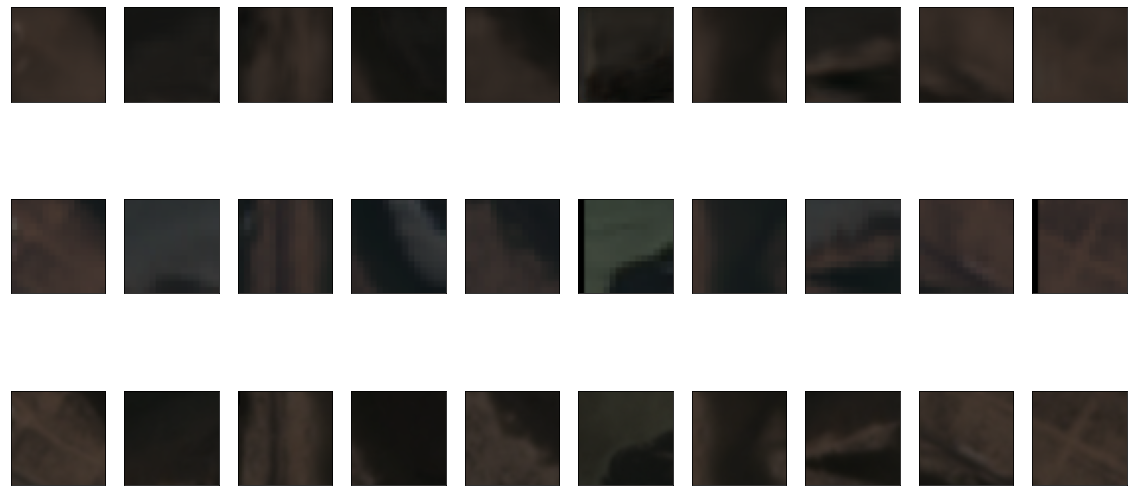

In [ ]:
import matplotlib.pyplot as plt

resolved_data = autoencoder.predict(lr_test)

print(resolved_data.shape)

n = 10  # how many digits we will display
plt.figure(3)
plt.figure(figsize=(20, 10))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(resolved_data[i,:,:,0:3])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display hidden layer representation
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(lr_test[i,:,:,0:3])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    print(lr_test[i,:,:,0:3].shape)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(hr_test[i,:,:,0:3])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

(674, 48, 48, 4)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)


<Figure size 432x288 with 0 Axes>

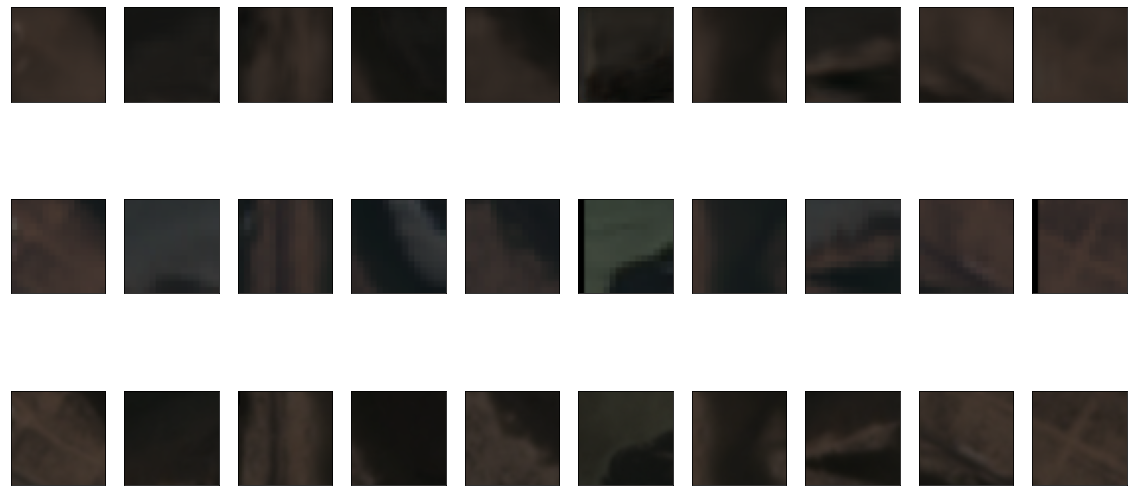

In [ ]:
resolved_data = autoencoder_aug.predict(lr_test)

print(resolved_data.shape)

n = 10  # how many digits we will display
plt.figure(3)
plt.figure(figsize=(20, 10))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(resolved_data[i,:,:,0:3])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display hidden layer representation
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(lr_test[i,:,:,0:3])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    print(lr_test[i,:,:,0:3].shape)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(hr_test[i,:,:,0:3])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

(674, 48, 48, 4)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)


<Figure size 432x288 with 0 Axes>

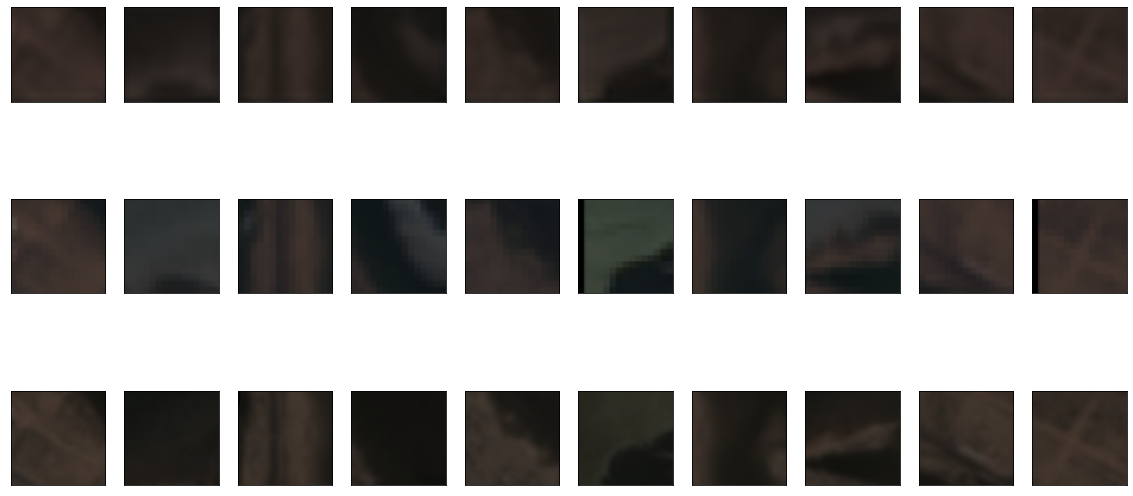

In [ ]:
resolved_data = srcnn.predict(lr_test)

print(resolved_data.shape)

n = 10  # how many digits we will display
plt.figure(3)
plt.figure(figsize=(20, 10))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(resolved_data[i,:,:,0:3])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display hidden layer representation
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(lr_test[i,:,:,0:3])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    print(lr_test[i,:,:,0:3].shape)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(hr_test[i,:,:,0:3])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

(674, 48, 48, 4)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)
(48, 48, 3)


<Figure size 432x288 with 0 Axes>

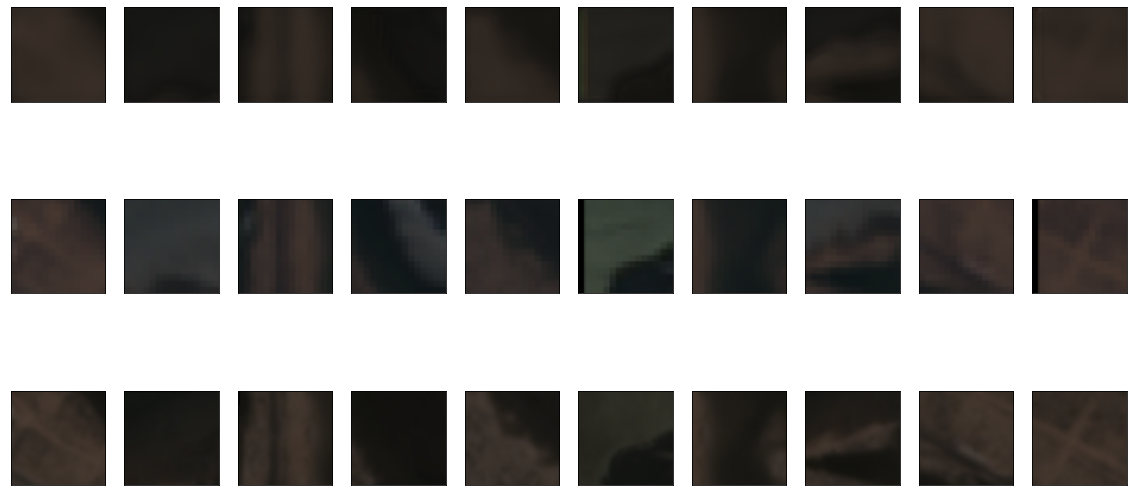

In [ ]:
resolved_data = srcnn_aug.predict(lr_test)

print(resolved_data.shape)

n = 10  # how many digits we will display
plt.figure(3)
plt.figure(figsize=(20, 10))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(resolved_data[i,:,:,0:3])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display hidden layer representation
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(lr_test[i,:,:,0:3])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    print(lr_test[i,:,:,0:3].shape)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(hr_test[i,:,:,0:3])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Making mosaic of the super-resolved tiles

In [ ]:
!mkdir sr_tiles
from fiona.crs import from_epsg
import rasterio
from rasterio.plot import reshape_as_raster, reshape_as_image

sr_test = autoencoder.predict(lr_test)
sr_train = autoencoder.predict(lr_train)


for i in tqdm(range(len(lr_test))):
    image = sr_test[i,:,:,:]
    meta = hr_test_meta[i]
    filename = test_filenames[i]
    transform = test_transforms[i]

    out_meta = meta.copy()
    out_meta.update({"driver": "GTiff","height": image.shape[0], "width": image.shape[1], "transform": transform})
    outpath = os.path.join("sr_tiles", "sr" + os.path.basename(filename))
    with rasterio.open(outpath, 'w', **out_meta) as outds:
        outds.write(reshape_as_raster(image))


for i in tqdm(range(len(lr_train))):
    image = sr_train[i,:,:,:]
    meta = hr_train_meta[i]
    filename = train_filenames[i]
    transform = train_transforms[i]
    out_meta = meta.copy()
    #fix shape
    out_meta.update({"driver": "GTiff","height": image.shape[0], "width": image.shape[1], "transform": transform})
    outpath = os.path.join("sr_tiles", "sr" + os.path.basename(filename))
    with rasterio.open(outpath, 'w', **out_meta) as outds:
        outds.write(reshape_as_raster(image))

  0%|          | 0/674 [00:00<?, ?it/s]

  0%|          | 0/2694 [00:00<?, ?it/s]

In [ ]:
!unzip test.zip -d testing

unzip:  cannot find or open test.zip, test.zip.zip or test.zip.ZIP.


In [ ]:
!rm -rf testing

In [ ]:
from cv2 import resize
import cv2

def load_unresolved(input_dir):
    target_filenames = [os.path.join(input_dir, x) for x in os.listdir(input_dir) if x.endswith(".tif")]
    lr_images = []

    lr_meta = []

    bounds = []
    for index in tqdm(range(len(target_filenames))):
        

        lr_image, lr_meta_cur = raster.load_image(target_filenames[index])

                
        lr_images.append(resize(reshape_as_image(lr_image.read()), (48,48), interpolation = cv2.INTER_AREA))
        
        lr_meta.append(lr_meta_cur)
        bounds.append(lr_image.bounds)

    return lr_images, lr_meta, target_filenames, bounds

In [ ]:
s1_images, s1_meta, s1_files, s1_bounds = load_unresolved("testing")

FileNotFoundError: ignored

In [ ]:
from rasterio.transform import from_bounds


s1_images = np.asarray(s1_images)
s1_resolved = autoencoder.predict(s1_images)

for i in tqdm(range(len(s1_files))):
    image = s1_resolved[i,:,:,:]
    meta = s1_meta[i]
    filename = s1_files[i]
    bounds = s1_bounds[i]
    out_meta = meta.copy()

    transform = from_bounds(bounds.left, bounds.bottom, bounds.right, bounds.top, image.shape[1], image.shape[0])
    #fix shape
    out_meta.update({"driver": "GTiff","height": image.shape[0], "width": image.shape[1], "transform": transform})
    outpath = os.path.join("sr_testing", "sr" + os.path.basename(filename))
    with rasterio.open(outpath, 'w', **out_meta) as outds:
        outds.write(reshape_as_raster(image))

In [ ]:
s1_images = np.asarray(s1_images)
s1_resolved = srcnn.predict(s1_images)

for i in tqdm(range(len(s1_files))):
    image = s1_resolved[i,:,:,:]
    meta = s1_meta[i]
    filename = s1_files[i]
    bounds = s1_bounds[i]
    out_meta = meta.copy()
    #fix shape

    transform = from_bounds(bounds.left, bounds.bottom, bounds.right, bounds.top, image.shape[1], image.shape[0])

    out_meta.update({"driver": "GTiff","height": image.shape[0], "width": image.shape[1], "transform": transform})
    outpath = os.path.join("sr_testing_2", "sr" + os.path.basename(filename))
    with rasterio.open(outpath, 'w', **out_meta) as outds:
        outds.write(reshape_as_raster(image))

In [ ]:
from rasterio.merge import merge
from rasterio.plot import show
import rasterio

src_files_to_mosaic = []

for fp in os.listdir("testing"):
    src = rasterio.open(os.path.join("testing", fp))
    src_files_to_mosaic.append(src)

mosaic, out_trans = merge(src_files_to_mosaic)
print(mosaic.shape)
plt.figure(figsize=(20, 20))
show(mosaic[0:3,:,:])

In [ ]:
from rasterio.merge import merge
from rasterio.plot import show

src_files_to_mosaic = []

for fp in os.listdir("sr_testing"):
    src = rasterio.open(os.path.join("sr_testing", fp))
    src_files_to_mosaic.append(src)

mosaic, out_trans = merge(src_files_to_mosaic)
print(mosaic.shape)
plt.figure(figsize=(20, 20))
show(mosaic[0:3,:,:])

In [ ]:
from rasterio.merge import merge
from rasterio.plot import show

src_files_to_mosaic = []

for fp in os.listdir("sr_testing_2"):
    src = rasterio.open(os.path.join("sr_testing_2", fp))
    src_files_to_mosaic.append(src)

mosaic, out_trans = merge(src_files_to_mosaic)
print(mosaic.shape)
plt.figure(figsize=(10, 10))

show(mosaic[0:3,:,:])